### Librariries

In [95]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
% matplotlib inline

import os
from copy import deepcopy

from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

from tqdm import tnrange, tqdm_notebook

from matplotlib import colors as mcolors
import random

import re

### Class

In [106]:
class Magniy(object):
    def __init__(self, file, model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini'), fold = "rna-ion-step2/", ):
        self.filename = file.split('.csv')[0]
        self.model = model
        self.trained_model = None
        self.data = pd.read_table(fold+file).dropna()        
        self.data_numpy = np.matrix(self.data)
        self.features = list(self.data.columns)[1:]
        self.groups = self.data_numpy[:,:1]
        self.x = self.data_numpy[:, 1:-1]
        self.xt = None
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])        
        
        self.importances = None
        self.train_score = []
        self.test_score= []
        self.test_roc_auc_score = []
       
    def choose_features(self, save_to_file = True, plot = True):
        classifier = self.model
        gss = GroupShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        for train_index, test_index in gss.split(self.x, self.y, groups = self.groups):        
            x_train = self.x[train_index]
            y_train = self.y[train_index]
            classifier.fit(x_train, y_train)
        model = SelectFromModel(classifier, prefit = True)
        self.xt = model.transform(self.x)
        print("Featurу reduction: %d -> %d"%(self.x.shape[1], self.xt.shape[1]))
        
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        if save_to_file:
            file = open('Ranked features, %s.txt'%self.filename, 'w')
            for f in range(self.x.shape[1]):
                file.write("%d. %s (%f)\n" % (f + 1, self.features[indices[f]], importances[indices[f]]))
            file.close()
        
        if plot:
            std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)              
            ax = plt.figure(figsize=(15, 5)).add_subplot(111)
            ax.set_title("Feature importances", fontsize = 15)
            block = ax.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], 
                           align="center", label = "importance")
            bord = ax.axvline(self.xt.shape[1], color='black', linestyle='--', alpha = 0.5)
            ax.set_xticks(list(plt.xticks()[0])+[self.xt.shape[1]])
            ax.set_xlim([0, x_train.shape[1]])
            ax.set_ylim([0, importances[indices][0]+int(np.amax(std)/2)])
            line = matplotlib.lines.Line2D([0,1], [1,1], color = "black")
            ax.legend([block, line, bord], ["importance","std", "edge"], fontsize = 12)
            plt.show()
            
        
    def fit_predict(self, n_splits = 3, test_size = 0.2, plots = True, redundant = True, model = False):
        if not model:
            self.trained_model = self.model
        else:
            self.trained_model = model
            
        colors = list(dict(mcolors.CSS4_COLORS).keys())
        
        if redundant:
            x = self.xt
        else:
            x = self.x
        y = self.y
        gss = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0) 
        if plots:
            ax = plt.figure(figsize=(18, 20)).add_subplot(311)
            learn = []
            learn_labels = []
    
        for train_index, test_index in tqdm_notebook(gss.split(x, y, groups=self.groups), desc = "Splits"):    
            x_train = x[train_index]
            y_train = y[train_index]
            x_test = x[test_index]
            y_test = y[test_index]

            self.trained_model.fit(x_train, y_train)
            y_pred = self.trained_model.predict(x_test)
            y_prob = self.trained_model.predict_proba(x_test)[:, 1]
            self.train_score.append(self.trained_model.score(x_train, y_train))
            self.test_score.append(accuracy_score(y_test, y_pred))
            self.test_roc_auc_score.append(roc_auc_score(y_test, y_prob))

            if plots:
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                learn = (ax.plot(fpr, tpr, color="red", alpha=0.5, label = ''))
        
        if plots:
            final = ax.plot(fpr, tpr, color="black", label = 'final curve')
            labels, inds = np.unique(learn_labels, return_index=True)
            learn = np.array(learn)[inds].tolist()
            ax.legend(learn+final, ["Learning rates",'final curve'], loc = 4, fontsize = 12)
            ax.set_title("ROC curves for random forests")

            ax = plt.figure(figsize=(18, 20)).add_subplot(312)
            ax.plot(list(range(len(self.train_score))), self.train_score, color = 'blue', label = 'Train accuracy')
            ax.plot(list(range(len(self.test_score))), self.test_score, color = 'orange', label = 'Test accuracy')
            ax.legend()
            ax.set_title('Accuracy scores', fontsize = 12)

            self.pres_recall(y_test, y_prob)
            plt.show()
            
    def pres_recall(self,y_test, y_prob):
        precision = {}
        recall = {}
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test,  y_prob)
        acc = average_precision_score(y_test, y_prob, average="micro")
        ax = plt.figure(figsize=(18, 20)).add_subplot(313)
        ax.plot(recall["micro"], precision["micro"], color="green", lw=2,
                 label='Random Forest (area = {0:0.2f})'
                       ''.format(acc))
        ax.legend(fontsize = 12)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title("Presicion-recall")
        
    def compute(self, n_splits = 3, test_size = 0.3, plots = True, reduce_features = True, save_to_file = True):
        if reduce_features:
            self.choose_features(save_to_file, plots)
        self.fit_predict(n_splits, test_size, plots, reduce_features)
        return self.test_score[-1]

Featurу reduction: 361 -> 129


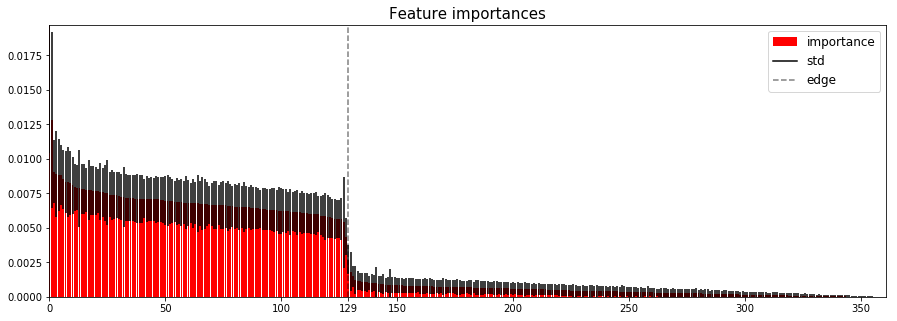

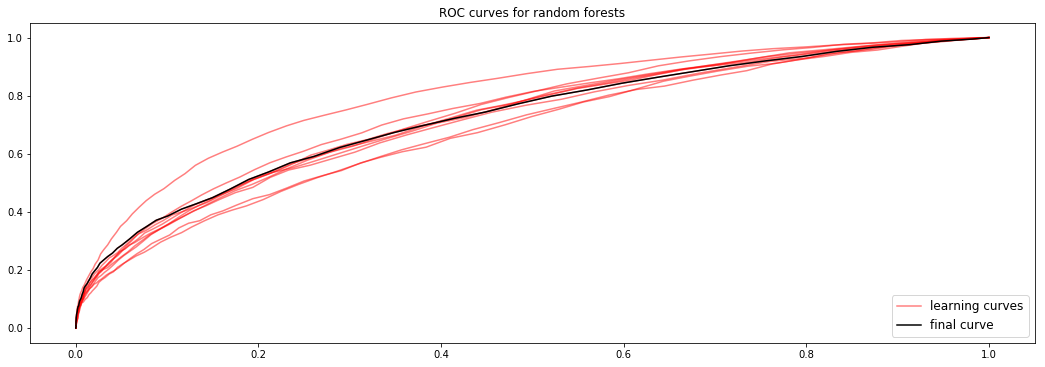

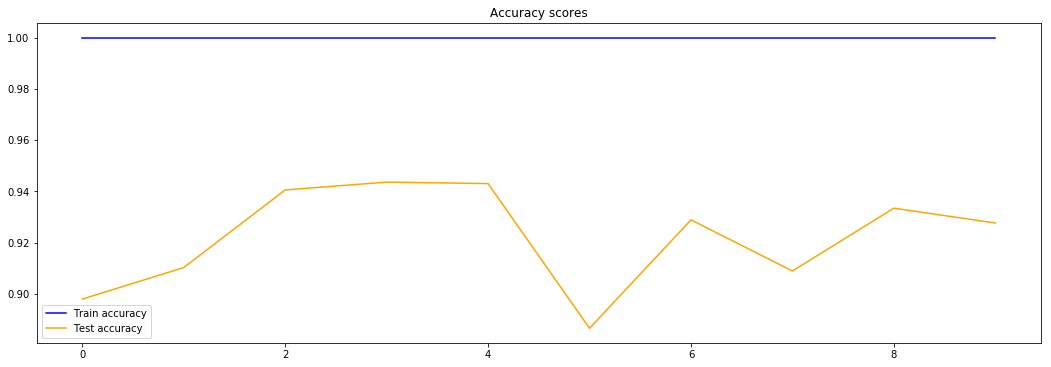

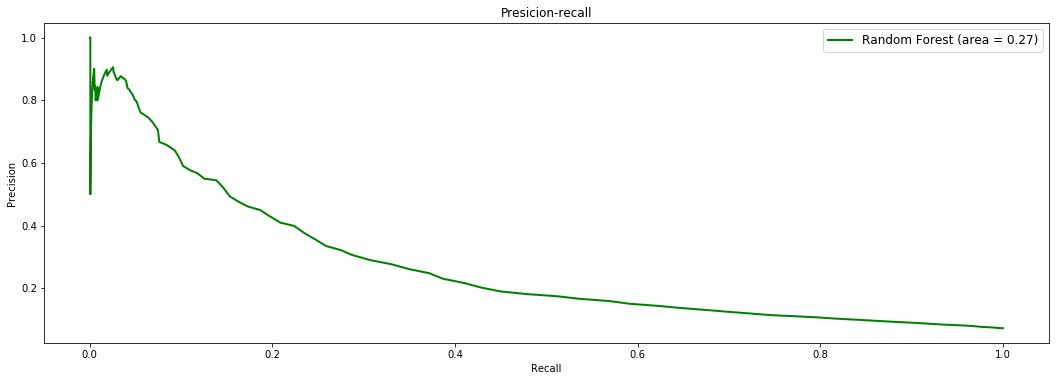

0.92766137078824162

In [41]:
m = Magniy("set_maxmg_N_3.csv")
m.compute(n_splits = 10)

### PCA

[ 0.44753622  0.04843719  0.03723274  0.02620461  0.02292014  0.02121137
  0.02026377  0.01811236  0.0173253   0.01693969]
x_train shape is (14091, 128)
y_train shape is (14091,)
Xt shape is (14091, 10)


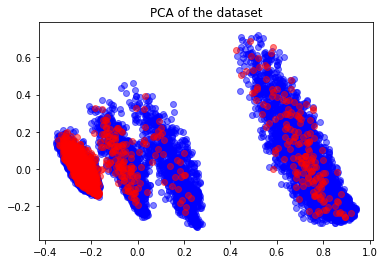

In [29]:
gss_base = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, test_index = list(gss_base.split(xt,y,groups = group))[0]
x_train = xt[train_index]
y_train = y[train_index]
x_test = xt[test_index]
y_test = y[test_index]

x_test_normed = preprocessing.normalize(x_test, norm='l2')
pca = PCA(n_components=10)
#Xt = pca.fit_transform(x_test_normed)
Xt = pca.fit_transform(x_test_normed)
print(pca.explained_variance_ratio_)

y_test = np.array(y_test)
y_test = np.ravel(y_test)
print("x_train shape is %s" % str(x_test.shape))    
print("y_train shape is %s" % str(y_test.shape))
print("Xt shape is %s" % str(Xt.shape))
red = [ind for ind in range(len(y_test)) if y_test[ind] >= 0.5]
blue = [ind for ind in range(len(y_test)) if y_test[ind] < 0.5]

plt.scatter(Xt[blue,0], Xt[blue,1], c='blue', alpha = 0.5)
plt.scatter(Xt[red,0], Xt[red,1], c='red', alpha = 0.5)
plt.title('PCA of the dataset')
plt.show()